In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

from icl_lens_sizing.preprocessing.preprocessing import prepare_training_data

In [4]:

path = "/Users/sortmanns/git/work/icl-lens-sizing/data/icl_data_2.csv"
df = pd.read_csv(path, sep=";", decimal=',')
df = df[['implantat_größe', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder','Lens-ICPL-Distance']]
for col in df.columns:
    df[col] = df[col].to_numpy(dtype=float)

# Initialer Test mit XGBoost
Wir beginnen mit der vollen Feature-Menge, teilen die Daten in Feature- und Zielvariablen.

In [7]:
# Feature Auswahl
features = ['implantat_größe', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']

# Feature Engineering
custom_features = None
# Präparieren der Datensätze zur Weiterverarbeitung
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,
                                                               custom_features=custom_features)

X_train, X_test, y_train, y_test = train_test_split(feature_df, target_df, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

xgb_regressor = xgb.XGBRegressor(
    objective='reg:absoluteerror',  # Specify the objective for regression
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage used in update to prevent overfitting
    max_depth=3,                  # Maximum tree depth
    subsample=0.8,                # Fraction of samples used for fitting the trees
    colsample_bytree=0.8,         # Fraction of features used for fitting the trees
    random_state=42               # Seed for reproducibility
)
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate the mean MSE
mae_scores = -cross_val_score(xgb_regressor, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
mean_mae = np.mean(mae_scores)
print(f"Mean Absolute Error: {mean_mae}")

"['implantat_name', 'auge'] not found in axis"
Mean Absolute Error: 152.24508754185268


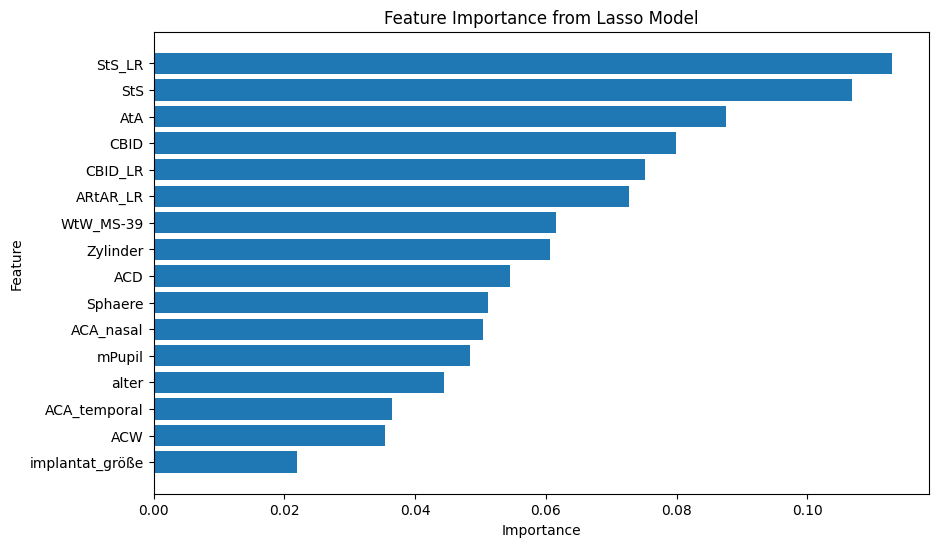

In [8]:
# Get the feature importance (coefficients) from the Lasso model
feature_importance = xgb_regressor.feature_importances_

# Create a DataFrame to hold feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({'Feature': feature_df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Tree Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

In [5]:
features = ['implantat_größe', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
       'WtW_MS-39', 'Sphaere']
sts_cbid = (lambda row: ((row['StS'] + row['CBID'])/2)-row['implantat_größe'])
custom_features = {'sts_cbid':sts_cbid}
# Präparieren der Datensätze zur Weiterverarbeitung
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,
                                                               custom_features=custom_features)

X_train, X_test, y_train, y_test = train_test_split(feature_df, target_df, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for col in feature_df.columns:
    feature_df[col] = feature_df[col].to_numpy(dtype=float)

xgb_regressor = xgb.XGBRegressor(
    objective='reg:absoluteerror',  # Specify the objective for regression
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage used in update to prevent overfitting
    max_depth=3,                  # Maximum tree depth
    subsample=0.8,                # Fraction of samples used for fitting the trees
    colsample_bytree=0.8,         # Fraction of features used for fitting the trees
    random_state=42               # Seed for reproducibility
)
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate the mean MSE
mae_scores = -cross_val_score(xgb_regressor, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
mean_mae = np.mean(mae_scores)
print(f"Mean Absolute Error: {mean_mae}")

"['implantat_name', 'auge'] not found in axis"
Mean Absolute Error: 135.9691219656808


In [11]:
sfsf = SequentialFeatureSelector(
    estimator=xgb_regressor,
    direction="forward",
    scoring="neg_mean_absolute_error"
)
sfsf.fit(feature_df, target_df)
sfsf.get_feature_names_out()


/Users/sortmanns/mambaforge/envs/icl-sizing/lib/python3.8/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


array(['implantat_größe', 'ACD', 'ACA_nasal', 'StS', 'StS_LR', 'CBID',
       'CBID_LR', 'Zylinder'], dtype=object)

In [15]:
features = ['implantat_größe', 'ACD', 'ACA_nasal', 'StS', 'StS_LR', 'CBID',
       'CBID_LR', 'Zylinder']
sts_cbid = (lambda row: ((row['StS'] + row['CBID'])/2)-row['implantat_größe'])
custom_features = {'sts_cbid':sts_cbid}
# Präparieren der Datensätze zur Weiterverarbeitung
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,
                                                               custom_features=None)

feature_df.drop(columns=['StS','CBID','implantat_größe'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(feature_df, target_df, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for col in feature_df.columns:
    feature_df[col] = feature_df[col].to_numpy(dtype=float)

xgb_regressor = xgb.XGBRegressor(
    objective='reg:absoluteerror',  # Specify the objective for regression
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage used in update to prevent overfitting
    max_depth=3,                  # Maximum tree depth
    subsample=0.8,                # Fraction of samples used for fitting the trees
    colsample_bytree=0.8,         # Fraction of features used for fitting the trees
    random_state=42               # Seed for reproducibility
)
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate the mean MSE
mae_scores = -cross_val_score(xgb_regressor, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
mean_mae = np.mean(mae_scores)
print(f"Mean Absolute Error: {mean_mae}")

"['implantat_name', 'auge'] not found in axis"
Mean Absolute Error: 136.3612815638951
